# Problem Description

Let's tackle an object detection problem.

I have modified three different images by adding a gaussian object to them. However, we do not know the parameters used to create the object.

We only know the coordinates of where the object was placed on the data (this is our truth data).

Our algorithm needs to output a guess of where the object is in the image ((x,y) coordinates).

Here are two images from the dataset we'll be using.

<img src="images/objects/24.931985579043406_227.21592826366043_1_1.png"> 
<img src="images/objects/34.63436638093823_284.21862680531655_2_1.png">

Can you tell where the gaussian object was added in? Hint: They are both near the top of the image

Essentially we have a *"Where's Waldo?"* problem. One of the objects in the image is the odd one out and our algorithm is tasked with finding it.

We'll start by reading in the images as a numpy array to make our dataset.

In [1]:
import numpy as np
import cv2
import os

folder = "images/objects/"

# get lists of numpy arrays
image_data = []
truth_data = []
directory = os.listdir(folder)
for img in directory:
    # get truth data
    truth = [float(i) for i in img.split("_")[:2]]
    # need to reverse the x and y because of image coord system
    # an image is (x,y) which is (row,col) unlike a coordinate system that is (col,row)
    truth_data.append(np.array([truth[1], truth[0]]))
    
    # get image data
    path = os.path.join(folder, img)
    grayscale = 0
    img_arr = cv2.imread(path, grayscale)
    image_data.append(img_arr)
    
print("Image Dimensions:", image_data[0].shape)
print("Dataset Size:", len(image_data))
print("Sample Truth Data:", truth_data[0])

Image Dimensions: (240, 426)
Dataset Size: 6
Sample Truth Data: [186.50309458 232.13007853]


# Proof of concept for the object detection algorithm

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy import signal
import sep

# method for creating gaussian kernels
def gaussian_kernel(size=21, std=3):
    """Returns a 2D Gaussian kernel array

    Args:
        size: defines the (size x size) kernel matrix
        std: standard deviation of gaussian (sigma)
    """
    # generate kernel data
    gkern_1d = signal.gaussian(size, std=std).reshape(size, 1)
    gkern_2d = np.outer(gkern_1d, gkern_1d)
    # normalize and return kernel matrix
    return (gkern_2d - np.mean(gkern_2d)) / np.std(gkern_2d)

def object_detection(image, size=11, std=1.5, threshold=10.0, minarea=5):
    # create kernel
    # I encourage you to play around with these parameters
    gkern = gaussian_kernel(size=size, std=std)

    # run SEP's matched_filtering
    # I encourage you to play around with the threshold and minarea
    objects = sep.extract(image, threshold, filter_kernel=gkern, minarea=minarea)
    print("Number of objects found:", len(objects))

    # initialize a dict for mapping objects to scores
    my_map = {}
    for obj in objects:
        # get radius of kernel
        s = (gkern.shape[0] - 1) // 2

        # pad input data with kernel radius
        # without the padding objects near the edge of the image will error out
        padded_data = cv2.copyMakeBorder(image, s, s, s, s, cv2.BORDER_REPLICATE)

        # grab center of object and pad it
        x = int(obj['y']) + s
        y = int(obj['x']) + s

        # slice our region of interest out of our original data
        # this will have the same nxn shape as the kernel
        roi = padded_data[x-s:x+s+1,y-s:y+s+1]

        # normalize roi
        # this is to prevent larger objects from having a bias
        if np.std(roi) > 0:
            roi = (roi - np.mean(roi)) / np.std(roi)

        # update object mapping with score
        my_map[(obj['x'],obj['y'])] = (roi * gkern).sum()

    # (argmax) find the key in the dictionary with the highest value
    max_coord = max(my_map.keys(), key=(lambda key: my_map[key]))
    
    return max_coord, objects

# Examples:

Number of objects found: 68
Number of objects found: 68
Prediction: [247.63390561 169.4904361 ]
Truth: [186.50309458 232.13007853]
Difference: [ 61.13081103 -62.63964244]
Total Error: 87.52542979901895


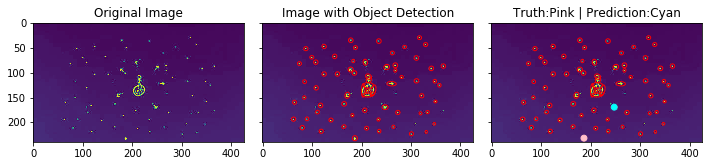

Number of objects found: 68
Number of objects found: 68
Prediction: [247.63390561 169.4904361 ]
Truth: [227.21592826  24.93198558]
Difference: [ 20.41797734 144.55845052]
Total Error: 145.99328551358218


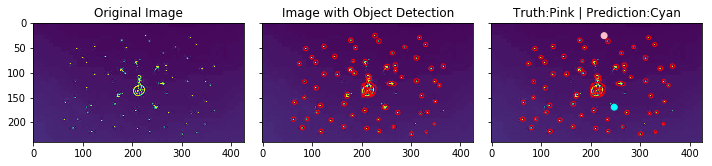

Number of objects found: 664
Number of objects found: 664
Prediction: [707.02165965 347.88292211]
Truth: [629.49833415 290.88800089]
Difference: [77.52332551 56.99492122]
Total Error: 96.21999294726035


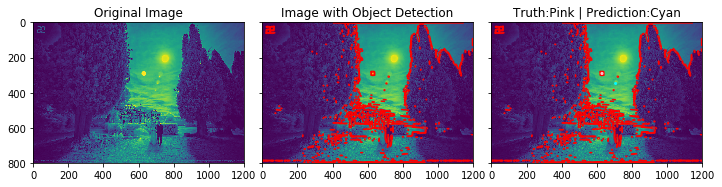

Number of objects found: 68
Number of objects found: 68
Prediction: [247.63390561 169.4904361 ]
Truth: [284.21862681  34.63436638]
Difference: [-36.5847212  134.85606972]
Total Error: 139.73045968788594


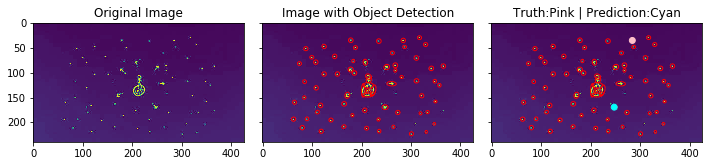

Number of objects found: 105
Number of objects found: 105
Prediction: [133.64454252  36.91646792]
Truth: [133.55204193  36.79264616]
Difference: [0.09250059 0.12382176]
Total Error: 0.1545580394621665


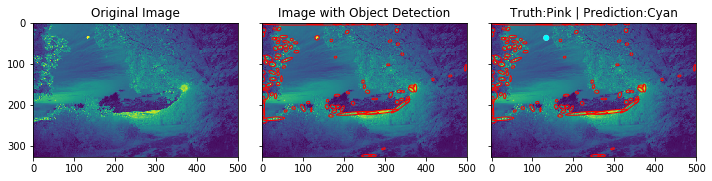

Number of objects found: 659
Number of objects found: 659
Prediction: [707.02165965 347.88292211]
Truth: [765.59374752 618.72510388]
Difference: [ -58.57208787 -270.84218176]
Total Error: 277.1031881794369


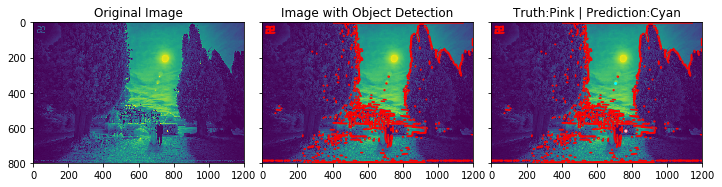

In [3]:
for image, truth in zip(image_data, truth_data):
    # run object detection
    max_coord, objects = object_detection(image, size=11, std=9, threshold=10.0, minarea=10)
    print("Number of objects found:", len(objects))
    
    # coordinates of selected object
    target = np.array(max_coord)
    print("Prediction:", target)
    print("Truth:", truth)

    # difference from truth data
    diff = target - truth
    print("Difference:", diff)

    # sum of the total error (distance)
    print("Total Error:", np.linalg.norm(diff).sum())
    
    titles = ['Original Image', 
              'Image with Object Detection',
              'Truth:Pink | Prediction:Cyan']
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
    ax = axes.ravel()
    
    for j in range(3):
        ax[j].set_title(titles[j])
        ax[j].imshow(image)
        if j > 0:
            # plot an ellipse for each object
            for i in range(len(objects)):
                e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                                width=6*objects['a'][i],
                                height=6*objects['b'][i],
                                angle=objects['theta'][i] * 180. / np.pi)
                e.set_facecolor('none')
                e.set_edgecolor('red')
                ax[j].add_artist(e)
            
        if j == 2:
            target_circle = plt.Circle(truth, 6, color='pink')
            ax[j].add_artist(target_circle)

            target_circle = plt.Circle(target, 6, color='cyan')
            ax[j].add_artist(target_circle)
            
    plt.tight_layout()
    plt.show()

# Skimage object detection

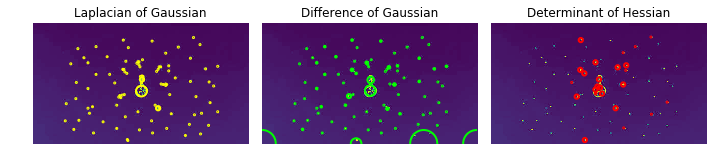

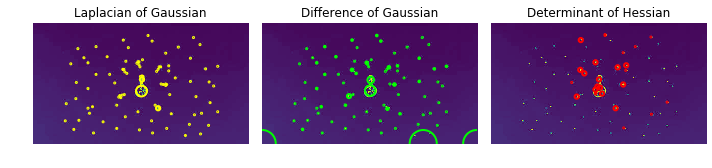

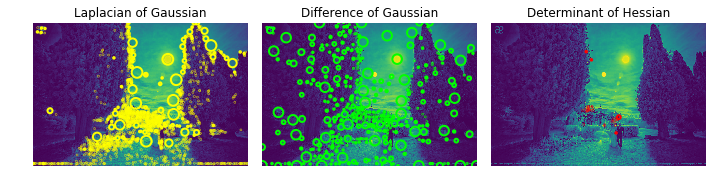

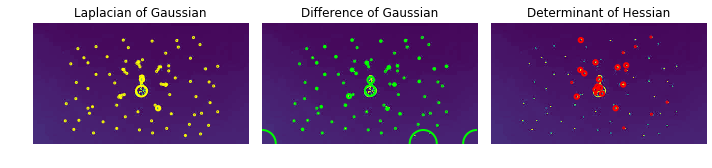

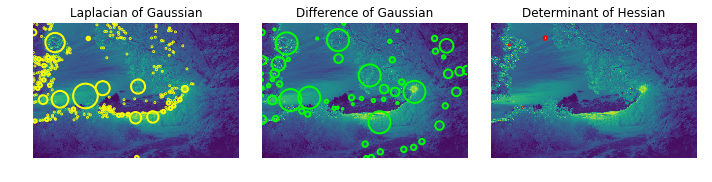

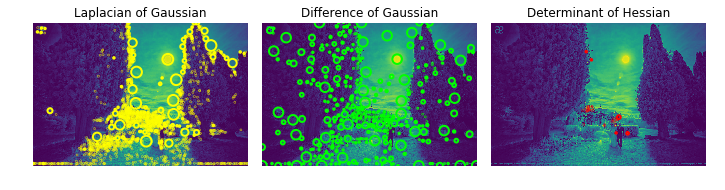

In [4]:
from skimage.feature import blob_dog, blob_log, blob_doh

for image, truth in zip(image_data, truth_data):
    blobs_log = blob_log(image, max_sigma=30, num_sigma=10, threshold=.1)
    
    blobs_dog = blob_dog(image, max_sigma=30, threshold=.1)
    
    blobs_doh = blob_doh(image, max_sigma=30, threshold=.01)
    
    blobs_list = [blobs_log, blobs_dog, blobs_doh]
    colors = ['yellow', 'lime', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
              'Determinant of Hessian']
    sequence = zip(blobs_list, colors, titles)

    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    for idx, (blobs, color, title) in enumerate(sequence):
        ax[idx].set_title(title)
        ax[idx].imshow(image, interpolation='nearest')
        for blob in blobs:
            y, x, r = blob
            c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
            ax[idx].add_patch(c)
        ax[idx].set_axis_off()

    plt.tight_layout()
    plt.show()

# General Methods

In [5]:
def obj_detection_wrap(image, detector, size=11, std=9):
    
    # create kernel
    gkern = gaussian_kernel(size=size, std=std)

    # generate some objects
    objects = detector(image)

    # initialize a dict for mapping objects to scores
    my_map = {}
    for obj in objects:
        # get radius of kernel
        s = (gkern.shape[0] - 1) // 2

        # pad input data with kernel radius
        # without the padding objects near the edge of the image will error out
        padded_data = cv2.copyMakeBorder(image, s, s, s, s, cv2.BORDER_REPLICATE)

        # grab center of object and pad it
        x = int(obj[0]) + s
        y = int(obj[1]) + s

        # slice our region of interest out of our original data
        # this will have the same nxn shape as the kernel
        roi = padded_data[x-s:x+s+1,y-s:y+s+1]

        # normalize roi
        # this is to prevent larger objects from having a bias
        if np.std(roi) > 0:
            roi = (roi - np.mean(roi)) / np.std(roi)

        # update object mapping with score
        my_map[(obj[1],obj[0])] = (roi * gkern).sum()

    # (argmax) find the key in the dictionary with the highest value
    max_coord = max(my_map.keys(), key=(lambda key: my_map[key]))
    
    return max_coord, objects

def plot_objects(image, objects):
    titles = ['Original Image', 
              'Image with Object Detection',
              'Truth:Pink | Prediction:Cyan']
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
    ax = axes.ravel()
    
    for i in range(3):
        ax[i].set_title(titles[i])
        ax[i].imshow(image)
        if j > 0:
            # plot a circle for each object
            for obj in objects:
                y, x, r = obj
                c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
                ax[i].add_patch(c)
                ax[i].set_axis_off()
            
        if i == 2:
            target_circle = plt.Circle(truth, 6, color='magenta')
            ax[i].add_artist(target_circle)

            target_circle = plt.Circle(target, 6, color='cyan')
            ax[i].add_artist(target_circle)
            
    plt.tight_layout()
    plt.show()

# Laplacian of Gaussian

Number of objects found: 91
Prediction: [247. 169.]
Truth: [186.50309458 232.13007853]
Difference: [ 60.49690542 -63.13007853]
Total Error: 87.43730543242204


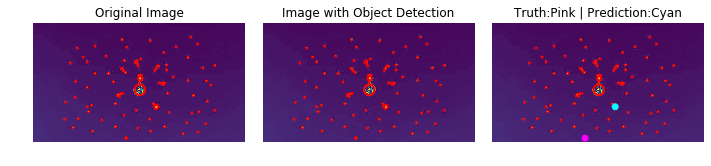

Number of objects found: 90
Prediction: [247. 169.]
Truth: [227.21592826  24.93198558]
Difference: [ 19.78407174 144.06801442]
Total Error: 145.42008896182668


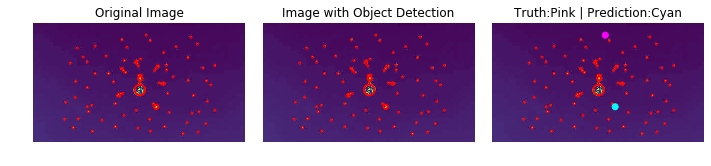

Number of objects found: 2080
Prediction: [720. 309.]
Truth: [629.49833415 290.88800089]
Difference: [90.50166585 18.11199911]
Total Error: 92.2962406286761


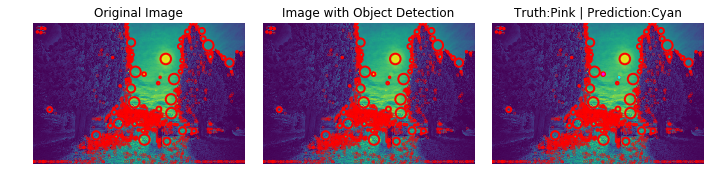

Number of objects found: 90
Prediction: [247. 169.]
Truth: [284.21862681  34.63436638]
Difference: [-37.21862681 134.36563362]
Total Error: 139.42506833107657


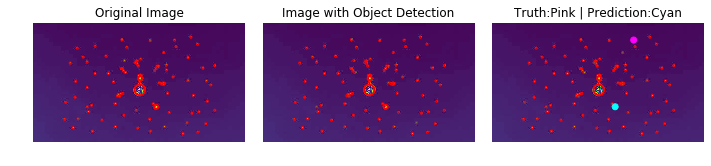

Number of objects found: 295
Prediction: [134.  37.]
Truth: [133.55204193  36.79264616]
Difference: [0.44795807 0.20735384]
Total Error: 0.4936213612661436


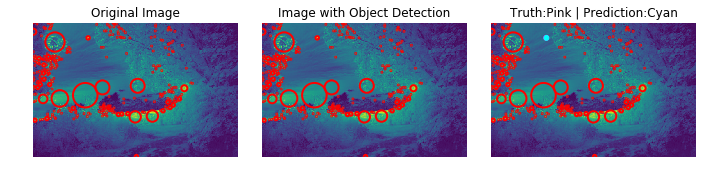

Number of objects found: 2081
Prediction: [720. 309.]
Truth: [765.59374752 618.72510388]
Difference: [ -45.59374752 -309.72510388]
Total Error: 313.0629805380226


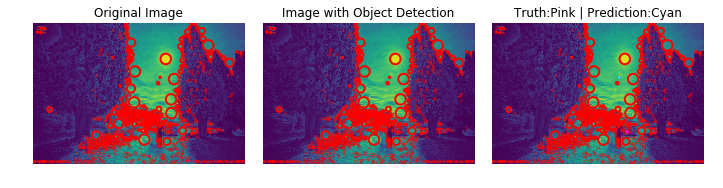

In [6]:
from functools import partial

def my_log(max_sigma=30, num_sigma=10, threshold=0.1):
    return partial(blob_log, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)

for image, truth in zip(image_data, truth_data):
    # initialize algorithm
    algo = my_log(max_sigma=30.0, num_sigma=10, threshold=0.1)
    
    # run object detection
    max_coord, objects = obj_detection_wrap(image, algo, size=11, std=9)
    print("Number of objects found:", len(objects))
    
    # coordinates of selected object
    target = np.array(max_coord)
    print("Prediction:", target)
    print("Truth:", truth)

    # difference from truth data
    diff = target - truth
    print("Difference:", diff)

    # sum of the total error (distance)
    print("Total Error:", np.linalg.norm(diff).sum())
    
    plot_objects(image, objects)


# Difference of Gaussian

Number of objects found: 76
Prediction: [262. 122.]
Truth: [186.50309458 232.13007853]
Difference: [  75.49690542 -110.13007853]
Total Error: 133.5230951037582


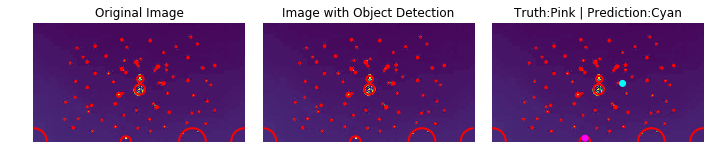

Number of objects found: 76
Prediction: [262. 122.]
Truth: [227.21592826  24.93198558]
Difference: [34.78407174 97.06801442]
Total Error: 103.11222560970087


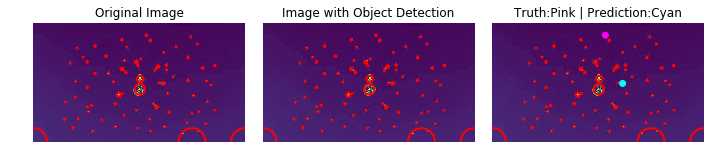

Number of objects found: 450
Prediction: [455.  49.]
Truth: [629.49833415 290.88800089]
Difference: [-174.49833415 -241.88800089]
Total Error: 298.2607476581438


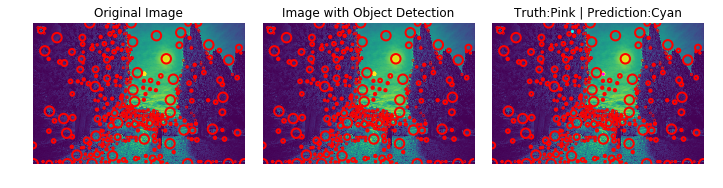

Number of objects found: 76
Prediction: [262. 122.]
Truth: [284.21862681  34.63436638]
Difference: [-22.21862681  87.36563362]
Total Error: 90.14666557767995


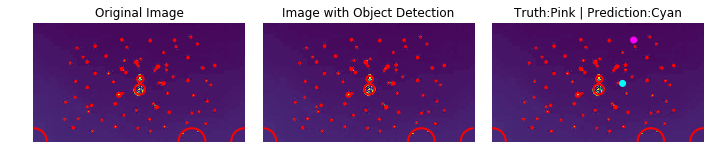

Number of objects found: 61
Prediction: [134.  37.]
Truth: [133.55204193  36.79264616]
Difference: [0.44795807 0.20735384]
Total Error: 0.4936213612661436


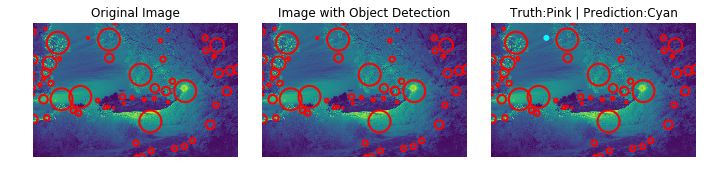

Number of objects found: 447
Prediction: [766. 619.]
Truth: [765.59374752 618.72510388]
Difference: [0.40625248 0.27489612]
Total Error: 0.4905190713265555


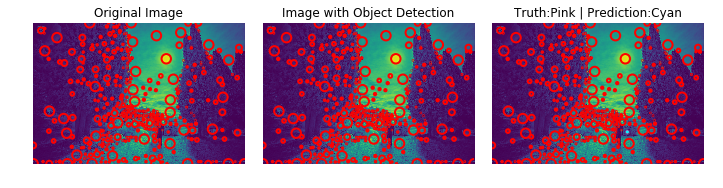

In [7]:
def my_dog(max_sigma=30, threshold=.1):
    return partial(blob_dog, max_sigma=max_sigma, threshold=threshold)

for image, truth in zip(image_data, truth_data):
    # initialize algorithm
    algo = my_dog(max_sigma=30, threshold=.1)
    
    # run object detection
    max_coord, objects = obj_detection_wrap(image, algo, size=11, std=9)
    print("Number of objects found:", len(objects))
    
    # coordinates of selected object
    target = np.array(max_coord)
    print("Prediction:", target)
    print("Truth:", truth)

    # difference from truth data
    diff = target - truth
    print("Difference:", diff)

    # sum of the total error (distance)
    print("Total Error:", np.linalg.norm(diff).sum())
    
    plot_objects(image, objects)


# Determinant of Hessian

Number of objects found: 25
Prediction: [247. 169.]
Truth: [186.50309458 232.13007853]
Difference: [ 60.49690542 -63.13007853]
Total Error: 87.43730543242204


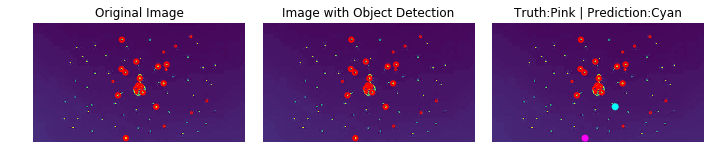

Number of objects found: 26
Prediction: [247. 169.]
Truth: [227.21592826  24.93198558]
Difference: [ 19.78407174 144.06801442]
Total Error: 145.42008896182668


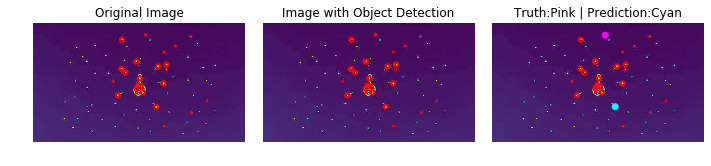

Number of objects found: 33
Prediction: [700. 616.]
Truth: [629.49833415 290.88800089]
Difference: [ 70.50166585 325.11199911]
Total Error: 332.6684488411414


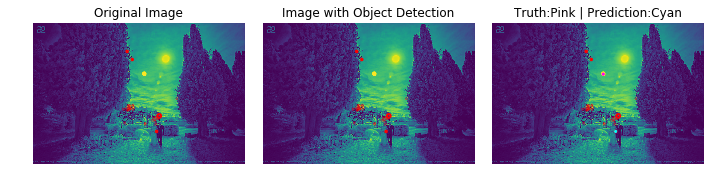

Number of objects found: 24
Prediction: [247. 169.]
Truth: [284.21862681  34.63436638]
Difference: [-37.21862681 134.36563362]
Total Error: 139.42506833107657


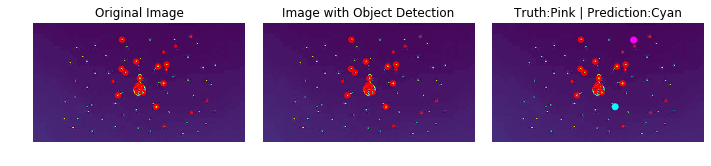

Number of objects found: 3
Prediction: [133.  36.]
Truth: [133.55204193  36.79264616]
Difference: [-0.55204193 -0.79264616]
Total Error: 0.9659390388696636


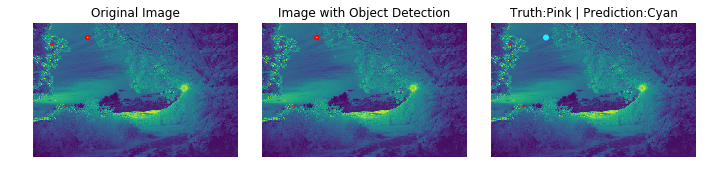

Number of objects found: 34
Prediction: [764. 618.]
Truth: [765.59374752 618.72510388]
Difference: [-1.59374752 -0.72510388]
Total Error: 1.7509445387200966


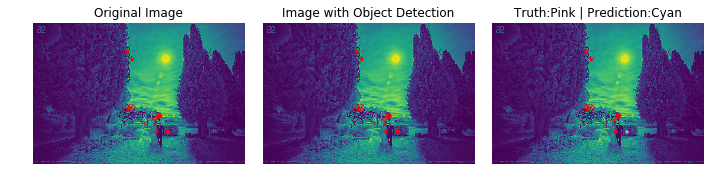

In [8]:
def my_doh(max_sigma=30, threshold=.01):
    return partial(blob_doh, max_sigma=max_sigma, threshold=threshold)

for image, truth in zip(image_data, truth_data):
    # initialize algorithm
    algo = my_doh(max_sigma=30, threshold=.01)
    
    # run object detection
    max_coord, objects = obj_detection_wrap(image, algo, size=11, std=9)
    print("Number of objects found:", len(objects))
    
    # coordinates of selected object
    target = np.array(max_coord)
    print("Prediction:", target)
    print("Truth:", truth)

    # difference from truth data
    diff = target - truth
    print("Difference:", diff)

    # sum of the total error (distance)
    print("Total Error:", np.linalg.norm(diff).sum())
    
    plot_objects(image, objects)

# OpenCV Blob Detection

Number of objects found: 4
Prediction: [214.59552002 107.96523285]
Truth: [186.50309458 232.13007853]
Difference: [  28.09242544 -124.16484568]
Total Error: 127.30315499232836


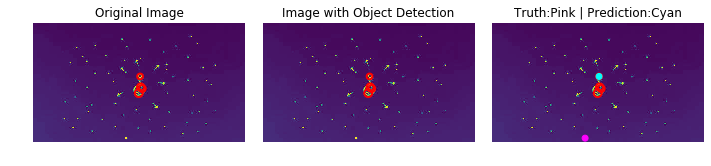

Number of objects found: 4
Prediction: [214.59552002 107.96523285]
Truth: [227.21592826  24.93198558]
Difference: [-12.62040824  83.03324727]
Total Error: 83.9868731199248


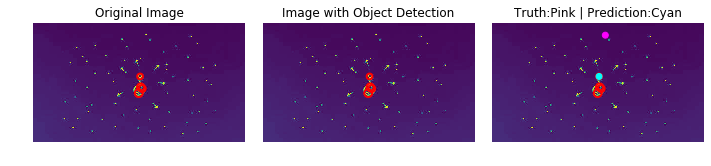

Number of objects found: 304
Prediction: [601.0335083  543.30133057]
Truth: [629.49833415 290.88800089]
Difference: [-28.46482585 252.41332968]
Total Error: 254.0132581370242


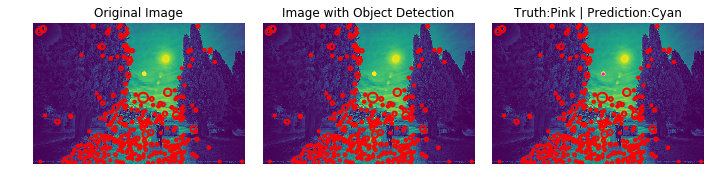

Number of objects found: 4
Prediction: [214.59552002 107.96523285]
Truth: [284.21862681  34.63436638]
Difference: [-69.62310679  73.33086647]
Total Error: 101.1177184052297


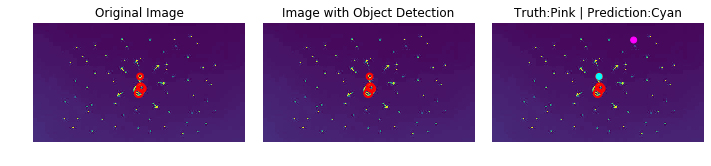

Number of objects found: 60
Prediction: [437.79574585  65.49841309]
Truth: [133.55204193  36.79264616]
Difference: [304.24370392  28.70576693]
Total Error: 305.5949155830327


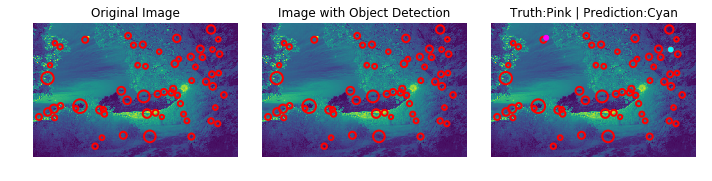

Number of objects found: 304
Prediction: [601.0335083  543.30133057]
Truth: [765.59374752 618.72510388]
Difference: [-164.56023922  -75.42377331]
Total Error: 181.02159515103583


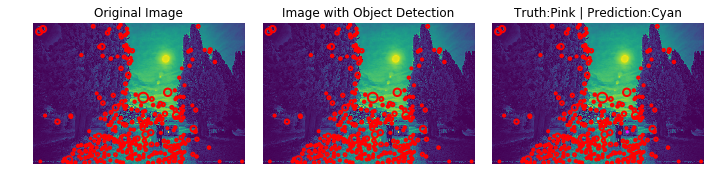

In [9]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 10;
params.maxThreshold = 200;
 
# Filter by Area.
params.filterByArea = True
params.minArea = 20
 
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1
 
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.8
 
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

# params.minDistBetweenBlobs = 2

# Set up the detector with default parameters.
detector = cv2.SimpleBlobDetector_create(params)
    
for image, truth in zip(image_data, truth_data):
    
    # create kernel
    gkern = gaussian_kernel(size=11, std=9)
    
    # Detect blobs.
    keypoints = detector.detect(image)
    objects = [(kp.pt[1], kp.pt[0], kp.size) for kp in keypoints]

    # initialize a dict for mapping objects to scores
    my_map = {}
    for obj in objects:
        # get radius of kernel
        s = (gkern.shape[0] - 1) // 2

        # pad input data with kernel radius
        # without the padding objects near the edge of the image will error out
        padded_data = cv2.copyMakeBorder(image, s, s, s, s, cv2.BORDER_REPLICATE)

        # grab center of object and pad it
        x = int(obj[0]) + s
        y = int(obj[1]) + s

        # slice our region of interest out of our original data
        # this will have the same nxn shape as the kernel
        roi = padded_data[x-s:x+s+1,y-s:y+s+1]

        # normalize roi
        # this is to prevent larger objects from having a bias
        if np.std(roi) > 0:
            roi = (roi - np.mean(roi)) / np.std(roi)

        # update object mapping with score
        my_map[(obj[1],obj[0])] = (roi * gkern).sum()

    # (argmax) find the key in the dictionary with the highest value
    max_coord = max(my_map.keys(), key=(lambda key: my_map[key]))
    print("Number of objects found:", len(objects))
    
    # coordinates of selected object
    target = np.array(max_coord)
    print("Prediction:", target)
    print("Truth:", truth)

    # difference from truth data
    diff = target - truth
    print("Difference:", diff)

    # sum of the total error (distance)
    print("Total Error:", np.linalg.norm(diff).sum())
    
    plot_objects(image, objects)

# Image Segmentation using WaterShed Algorithm

## OpenCV

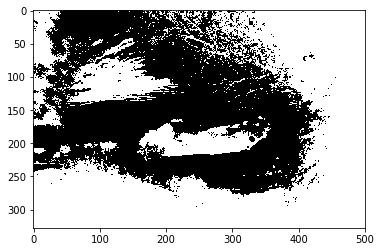

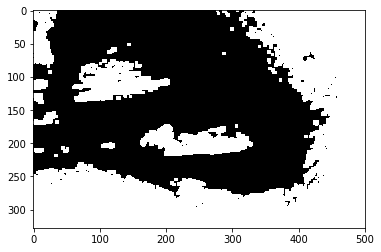

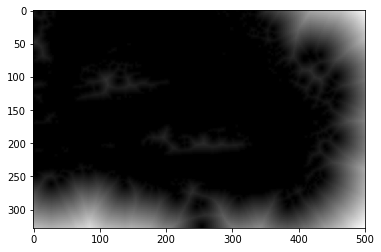

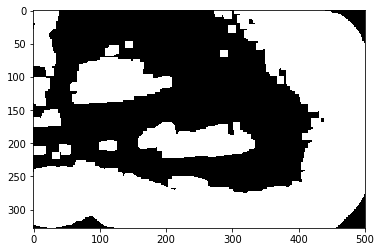

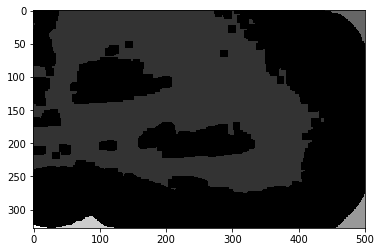

In [36]:
image = image_data[4]

# Otsu’s binarization
ret, thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(thresh, cmap='gray')
plt.show()

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

plt.imshow(opening, cmap='gray')
plt.show()

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

plt.imshow(dist_transform, cmap='gray')
plt.show()

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

plt.imshow(unknown, cmap='gray')
plt.show()

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers, cmap='gray')
plt.show()

# markers = cv2.watershed(image,markers)
# image[markers == -1] = [255,0,0]

# plt.imshow(image, cmap='gray')
# plt.show()

## Skimage Watershed and Reconstruction

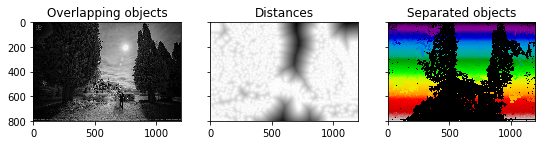

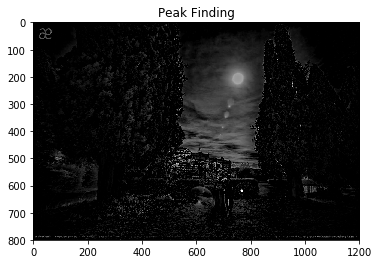

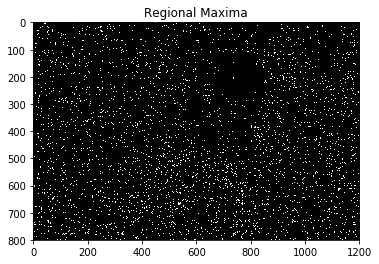

In [38]:
from scipy import ndimage

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.morphology import reconstruction

image = image_data[5]

distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((5, 5)),
                            labels=image)
markers = ndimage.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

plt.show()

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
rec = reconstruction(seed, image, method='dilation')

plt.imshow(image-rec, cmap='gray')
plt.title("Peak Finding")
plt.show()

seed = np.copy(image).astype(np.float64)
seed -= 0.4
rec = reconstruction(seed, image, method='dilation')

plt.imshow(image-rec, cmap='gray')
plt.title("Regional Maxima")
plt.show()

Peak finding does show a slight improvement on object detection